In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import variation
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import r2_score, mean_absolute_error
rcParams['figure.figsize'] = 10,10
from scipy.spatial.distance import cdist
from fuzzywuzzy import fuzz
import re
import sys
import pickle as pkl 
from tqdm import tnrange, tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sparse_dot_topn import awesome_cossim_topn
from sklearn.metrics.pairwise import cosine_similarity
import time

/home/gsimmons/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Custom functions

In [2]:
from matching import row_corr

### Load the NCC Data

In [4]:
ncc = pd.read_csv('../data/NCC_2018_nutrients_per_100g_originalcolnames.txt',sep='\t')

ncc = ncc.rename(columns={'Food ID':'NCC Food ID'})

### Load the data from the ASA24 Recalls

In [461]:
asa_24 = pd.read_csv('../data/training_for_GS_122118.csv')

### Load the file listing matching columns between the datasets

In [7]:
matching = pd.read_csv('../data/matching_ncc_fndds_columns.txt',sep='\t')

Get the list of columns for each dataset

In [8]:
ncc_cols = matching['NCC.Term'].values.tolist()
asa_24_cols = matching['FNDDS.Term'].values.tolist()
asa_24_cols = [val.replace(" ","") for val in asa_24_cols]

### Calculate the pairwise correlations

Get the columns provided by the `matching` file

In [9]:
A = asa_24.loc[:,asa_24_cols].values
B = ncc.loc[:,ncc_cols].values

In [10]:
corr = row_corr(A,B)

/share/lemaylab-backedup/lactoseML/scripts/matching.py:18: RuntimeWarning: divide by zero encountered in true_divide
  pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))
/share/lemaylab-backedup/lactoseML/scripts/matching.py:18: RuntimeWarning: invalid value encountered in true_divide
  pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))


### Calculate weighted pairwise correlations

Load the weights from the Lasso model

In [11]:
# lasso_coef = pd.read_csv('lasso_coef.csv')
# weights = lasso_coef.loc[:,'coef'].values[:-1] #omit 'year'

Define a function to calculate weighted row-wise PCC

In [12]:
# def row_corr_weighted(A,B,weights):
# # converted to python from here: https://stackoverflow.com/questions/9460664/weighted-pearsons-correlation
#     w = weights/sum(weights)
    
#     A = A - (A*w).sum(1)[:,None]
#     B = B - (B*w).sum(1)[:,None]
    
#     pcorr = np.matmul(A,((B*w).T))/np.sqrt(np.matmul(((A**2)*w).sum(1)[:,None],(((B**2)*w).sum(1)[:,None]).T))
#     return pcorr

In [13]:
# corr_weighted = row_corr_weighted(A,B,weights)

### Calculate similarity between labels

Preprocess the food names, remove delimiting characters and set to lower case

In [370]:
A_labels = asa_24.Food_Description.values

B_labels = ncc['Short Food Description'].values

A_labels = [re.sub('[.\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in A_labels]
B_labels = [re.sub('[.\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in B_labels]

### TF-IDF

Compute the tf-idf vector for each label, then match labels based on cosine similarity. tf-idf stands for Term Frequency-Inverse Document Frequency. In this case it is used to generate a unique numerical vector that is representative of the text content in each label.

N-gram code and inspiration from: https://bergvca.github.io/2017/10/14/super-fast-string-matching.html

Define a function to generate all n-grams from each label, to be used as analyzer in tf-idf vectorizer

Copied from the above link with some minor changes, one of which is repeating the first chunk twice. "Chunks" are comma-separated portions of each string (not a technical definition) so "Condensed milk, low fat" would be two chunks. It seems like the first "chunk" tends to be more informative in describing WHAT the food is, while other chunks tend to be modifiers ("low fat", "without cheese", preparation method, flavor, etc.). Repeating the first chunk essentially gives more weight to the tokens in this chunk when computing tf-idf.

Other change is including whole chunks as tokens in addition to just the 3-grams. This is optional, only took .01 off the MAE, but since it helped a tiny bit I left it in.

In [371]:
def ngrams(string, n=3):
    comma_sep_chunks = [tok.strip() for tok in string.split(',')]
    string = ' '.join([comma_sep_chunks[0]] + comma_sep_chunks) # repeat first chunk
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams] + comma_sep_chunks

Concatenate the labels from A (ASA24) and B (NCC) datasets

In [372]:
all_labels = A_labels + B_labels

Fit tf-idf vectorizer to the full set of labels, compute tf-idf vectors for A and B

In [373]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(all_labels)
tf_idf_A = vectorizer.transform(A_labels)
tf_idf_B = vectorizer.transform(B_labels)

Compute similarity matrix between A and B labels using cosine similarity

In [374]:
tf_idf_sim = np.array(cosine_similarity(tf_idf_A,tf_idf_B))

### Get results (unweighted)

Combine the tf-idf similarity and pcc similarity matrices using element-wise multiplication

In [428]:
combined_sim = np.multiply(tf_idf_sim,corr)

Get indices of the top matches from the combined similarity matrix

In [429]:
TOP = 5 # set the number of matches to return

indices_top = np.argsort(-combined_sim,axis=1,)[:,:TOP]
pcc_top = np.sort(-combined_sim,axis=1,)[:,:TOP]

Construct dataframe to store top results

In [430]:
iters = [np.arange(0,asa_24.shape[0],1).tolist(),np.arange(0,TOP,1).tolist()]

results_cols = asa_24.columns.values.tolist() + ['PCC'] + ncc.columns.values.tolist()

mi = pd.MultiIndex.from_product(iters, names=['asa_index', 'match_index'])

results_top = pd.DataFrame(index=mi,columns=results_cols)

Copy ASA24 values to left side

In [431]:
results_top.loc[results_top.eval('match_index==0'), asa_24.columns] = asa_24.values

results_top.loc[:,ncc.columns] = ncc.iloc[indices_top.flatten(),:].values

results_top.loc[:,'PCC'] = -pcc_top.flatten()

In [432]:
variations = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(variation))

/software/anaconda3/4.5.12/lssc0-linux/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


In [433]:
for index in results_top.index.get_level_values(0).unique():
    results_top.loc[index,'variation'] = variations.loc[index,:].values[0]

### Save results to CSV

In [434]:
name = 'pcc_tfidf_matching_results_top_{}.tsv'.format(TOP)
path = '../data/' + name
results_top.to_csv(path,sep='\t',index=False)

In [435]:
desc_only_cols = ['FoodCode','Food_Description','year','lac.per.100g','PCC','NCC Food ID','Keylist','Food Description','Short Food Description','Food Type','Lactose (g)','variation']

In [450]:
results_top_desc_only = results_top[desc_only_cols]

In [437]:
name = 'pcc_tfidf_matching_results_top_{}_desc_only.tsv'.format(TOP)
path = '../data/' + name
results_top_desc_only.to_csv(path,sep='\t',index=False)

### Load the data back in
(Check that it was saved, further analysis, etc.)

In [446]:
# results_top_desc_only_w =  pd.read_csv('../data/pcc_matching_results_top_5_weighted_desc_only.tsv',sep='\t')

In [447]:
# results_top_w = pd.read_csv('../data/pcc_matching_results_top_5_weighted.tsv',sep='\t')
# results_top = pd.read_csv('../data/pcc_matching_results_top_5.tsv',sep='\t')

In [448]:
# results_top_desc_only =  pd.read_csv('../data/pcc_tfidf_matching_results_top_5_desc_only.tsv',sep='\t')

### Evaluate results

Get first matches only in a dataframe

In [451]:
first_matches = results_top.loc[(results_top_desc_only.index.get_level_values('match_index') == 0)]

Add a column indicating the error between matched and labelled lactose

In [452]:
first_matches['error'] = abs(first_matches['lac.per.100g'] - first_matches['Lactose (g)'])

/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


View the first matches, sorted by error

In [453]:
first_matches[desc_only_cols + ['error']].sort_values('error',ascending=False)

,,FoodCode,Food_Description,year,lac.per.100g,PCC,NCC Food ID,Keylist,Food Description,Short Food Description,Food Type,Lactose (g),variation,error
asa_index,match_index,,,,,,,,,,,,,
127,0,95201000,"Carnation Instant Breakfast, nutritional drink...",2016,21.3108,0.517833,112894,SPEC.DNK.BRE.REG.CHO.COM.C03,"special formulated products, drinks, instant b...",Carnation Instant Breakfast Essentials - Dark ...,R,6.692,0.543541,14.6188
128,0,95220010,"Nutritional drink mix or meal replacement, hig...",2016,12.7154,0.563945,23914,SPEC.POW.MEA.DEF,"special formulated products, dry powders - unp...","Meal replacement drink, dry mix (unprepared)",X,4.937,0.862049,7.77838
17,0,41430310,Protein diet powder with soy and casein,2014,12.5452,0.434570,117597,SPEC.POW.PRO.18,"special formulated products, dry powders - unp...","Whey protein powder, 18 grams of protein per s...",X,5.214,0.916278,7.33116
29,0,91705420,"Chocolate, white, with cereal",2014,3.25,0.602895,26365,CAND.CHOC.CB.WHI,"candy, chocolate candy, chocolate candy bar, w...",White chocolate bar,C,9.8,0.661250,6.55
4,0,13210250,"Pudding, chocolate, ready-to-eat, low calorie,...",2014,0.22385,0.444011,17843,DESS.PUDD.CHO.MIX.REG.CKD,"desserts - miscellaneous, pudding, chocolate, ...","Chocolate pudding, from mix, cooked",R,4.684,0.156902,4.46015
21,0,56203210,"Oatmeal, NS as to regular, quick, or instant, ...",2014,4.27863,0.421128,1895,INGR.OAT.REG,"ingredient, oatmeal - dry, regular or quick","Oatmeal, regular or quick cooking, dry",C,0,1.504494,4.27863
91,0,56203212,"Oatmeal, cooked, quick (1 or 3 minutes), made ...",2016,4.27863,0.334307,1895,INGR.OAT.REG,"ingredient, oatmeal - dry, regular or quick","Oatmeal, regular or quick cooking, dry",C,0,1.121466,4.27863
298,0,92101900,"Coffee, Latte",2016,4.05345,0.442165,17429,BEVE.COFF.RC,"beverages, coffee, reduced caffeine","Coffee, reduced caffeine",X,0,NaN,4.05345
211,0,92101900,"Coffee, latte W/ WHOLE MILK",2014,4.05345,0.414316,25459,BEVE.COFF.FLA.REG,"beverages, coffee, with flavored syrup added, ...","Coffee, with flavored syrup",R,0,NaN,4.05345


#### Compute error measures

In [454]:
# labeled_lactose = results_top.loc[:,'lac.per.100g']
# labeled_lactose = labeled_lactose[~np.isnan(labeled_lactose)].values()

labeled_lactose_first = first_matches['lac.per.100g']
lookup_lactose_first = first_matches['Lactose (g)']
lookup_lactose_mean_top = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(np.mean)).values.flatten()
# labeled_lactose_nonzero = labeled_lactose[labeled_lactose != 0]
# lookup_lactose_nonzero = lookup_lactose[labeled_lactose != 0]

In [459]:
def mean_absolute_percentage_error_nz(y_true, y_pred): 
    """Compute mean absolute percentage error (MAPE) between actual and predicted vectors, where actual is nonzero"""
    y_true_nz = y_true[y_true != 0]
    y_pred_nz = y_pred[y_true != 0]
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

In [460]:
def score(actual,pred):
    """compute and display MAE, MAPE, R2 between actual and predicted vectors"""
    print('MAE: {}'.format(round(mean_absolute_error(actual,pred),2)))
    print('MAPE: {}'.format(round(mean_absolute_percentage_error_nz(actual,pred),2)))
    print('R2: {}'.format(round(r2_score(actual,pred),2)))

#### Results

First matches

In [457]:
score(labeled_lactose_first,lookup_lactose_first)

MAE: 0.48
MAPE: 209.51
R2: 0.77


Mean of top 5 matches

In [458]:
score(labeled_lactose_first,lookup_lactose_mean_top)

MAE: 0.87
MAPE: 298.3
R2: 0.61


#### Actual vs Predicted plots

In [404]:
def plot_results(actual,pred,title):
    """actual vs. predicted plot"""
    plt.scatter(x=actual,y=pred,s=3)
    plt.xlabel('Dietitian-selected value')
    plt.ylabel('Matched value')
    plt.title(title)

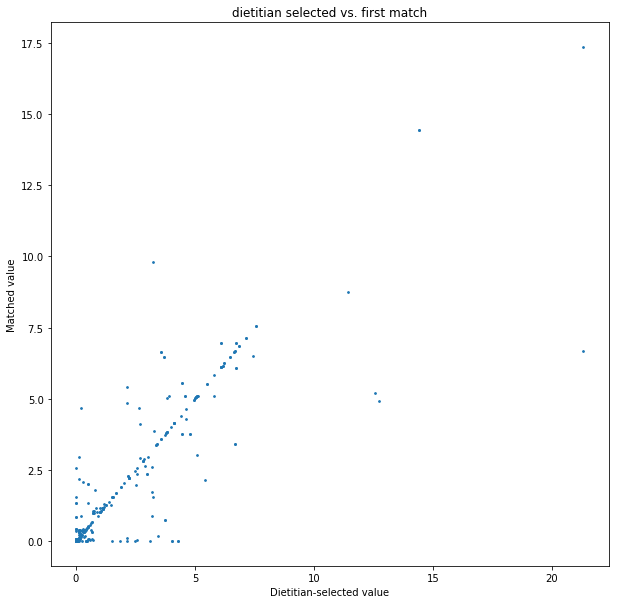

In [405]:
plot_results(labeled_lactose_first,lookup_lactose_first,'dietitian selected vs. first match')

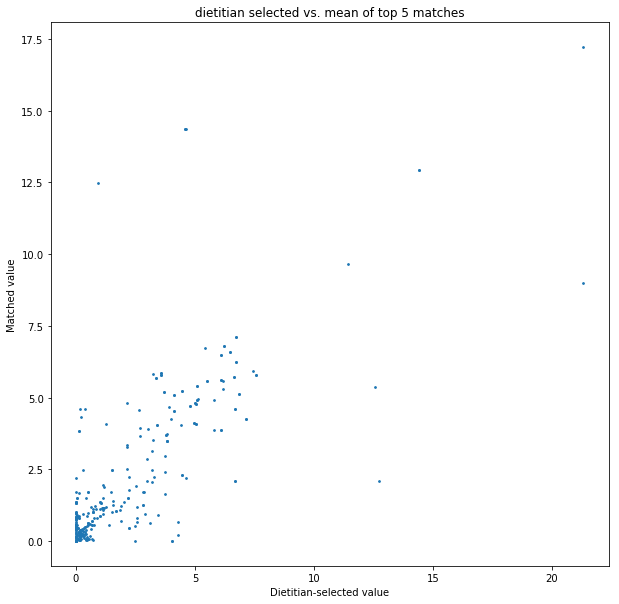

In [406]:
plot_results(labeled_lactose_first,lookup_lactose_mean_top,'dietitian selected vs. mean of top 5 matches')